In [1]:
# Step 1: Install necessary libraries
!pip install -q pyedflib numpy pandas scipy matplotlib neurokit2

Loaded EDF File with 7 signals.
Signal Labels: ['EEG Fpz-Cz', 'EEG Pz-Oz', 'EOG horizontal', 'Resp oro-nasal', 'EMG submental', 'Temp rectal', 'Event marker']


/opt/miniconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


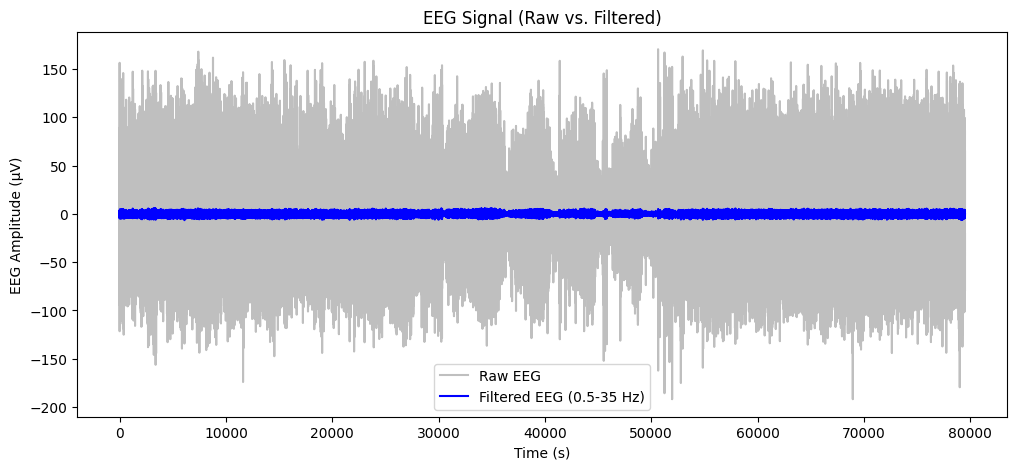

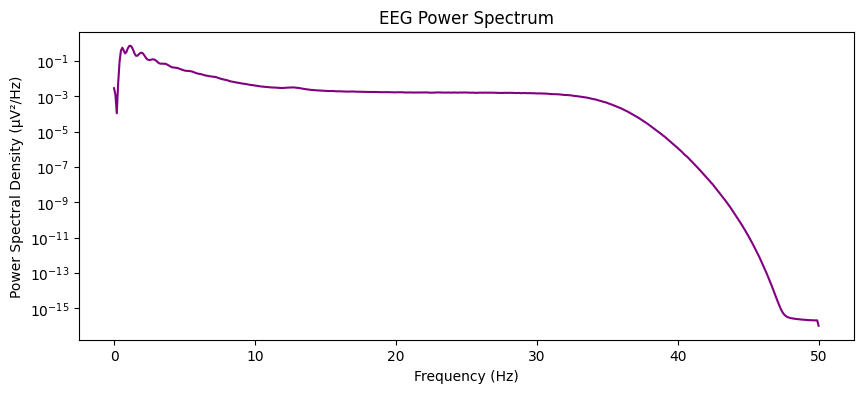

Number of Features Extracted per Epoch: 6


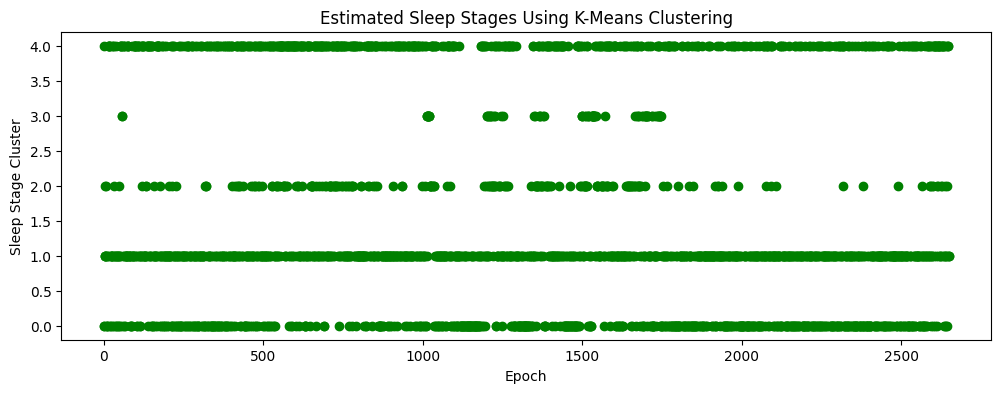

In [18]:
# Step 2: Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.signal as signal
import pyedflib
import neurokit2 as nk
import requests
import tempfile
from sklearn.cluster import KMeans

#Step 3: Load Sleep-EDF Data from URL
URL = "https://www.physionet.org/files/sleep-edfx/1.0.0/sleep-cassette/SC4001E0-PSG.edf?download"

#Fetch file content from the URL
response = requests.get(URL)
if response.status_code != 200:
    raise ValueError("⚠️ Failed to fetch EDF file from PhysioNet.")

#Save to a temporary file
with tempfile.NamedTemporaryFile(delete=False, suffix=".edf") as tmpfile:
    tmpfile.write(response.content)
    edf_path = tmpfile.name  # Store path for reading

#Step 4: Read the EDF file
edf_reader = pyedflib.EdfReader(edf_path)
n_signals = edf_reader.signals_in_file
signal_labels = edf_reader.getSignalLabels()

print(f" Loaded EDF File with {n_signals} signals.")
print(f" Signal Labels: {signal_labels}")

# Step 5: Extract EEG signals
eeg_signal = np.array(edf_reader.readSignal(0), dtype=np.float32)  # Convert to NumPy array
fs = int(edf_reader.getSampleFrequency(0))  # Sampling frequency as integer
edf_reader.close()

# Step 6: Bandpass Filter (0.5 - 35 Hz) for EEG
lowcut, highcut = 0.5, 35.0
b, a = signal.butter(4, [lowcut / (fs / 2), highcut / (fs / 2)], btype='band')
filtered_eeg = signal.filtfilt(b, a, eeg_signal)

# Step 7: Normalize EEG
filtered_eeg = (filtered_eeg - np.mean(filtered_eeg)) / np.std(filtered_eeg)

# Step 8: Plot Raw EEG vs Filtered EEG
plt.figure(figsize=(12, 5))
plt.plot(np.arange(len(eeg_signal)) / fs, eeg_signal, label="Raw EEG", color="gray", alpha=0.5)
plt.plot(np.arange(len(filtered_eeg)) / fs, filtered_eeg, label="Filtered EEG (0.5-35 Hz)", color="blue")
plt.xlabel("Time (s)")
plt.ylabel("EEG Amplitude (µV)")
plt.title("EEG Signal (Raw vs. Filtered)")
plt.legend()
plt.show()

# Step 9: Compute Power Spectral Density (PSD)
freqs, psd = signal.welch(filtered_eeg, fs, nperseg=1024)

plt.figure(figsize=(10, 4))
plt.semilogy(freqs, psd, color='purple')
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density (µV²/Hz)")
plt.title("EEG Power Spectrum")
plt.show()

# Step 10: Segment EEG into 30-Second Epochs
epoch_duration = 30  # Each epoch = 30 sec
samples_per_epoch = int(fs * epoch_duration)  # Ensure integer
num_epochs = int(len(filtered_eeg) // samples_per_epoch)  # Ensure integer

# Create DataFrame for Epochs
eeg_epochs_dict = {}
for i in range(num_epochs):
    start = i * samples_per_epoch
    end = start + samples_per_epoch
    eeg_epochs_dict[f"Epoch_{i}"] = filtered_eeg[start:end]

# Convert to DataFrame
eeg_epochs_df = pd.DataFrame.from_dict(eeg_epochs_dict, orient="index").T

# Step 11: Extract EEG Power Features for Each Epoch
eeg_features = []
for epoch in eeg_epochs_df.T.values:
    eeg_power = nk.eeg_power(pd.DataFrame(epoch), sampling_rate=fs)  # Removed `relative=True`
    eeg_features.append(eeg_power.mean().values)  # Extract mean power per band

# Debugging: Print EEG Feature Shape
print(f" Number of Features Extracted per Epoch: {len(eeg_features[0])}")

# Convert to DataFrame (Auto Handle Column Names)
eeg_features_df = pd.DataFrame(eeg_features)

# Step 12: Sleep Staging with K-Means Clustering
num_sleep_stages = 5  # Approximate sleep stages (N1, N2, N3, REM, Wake)
kmeans = KMeans(n_clusters=num_sleep_stages, random_state=42)
sleep_stages = kmeans.fit_predict(eeg_features_df)

# Step 13: Plot Sleep Stages
plt.figure(figsize=(12, 4))
plt.plot(sleep_stages, color='green', marker='o', linestyle="None")
plt.xlabel("Epoch")
plt.ylabel("Sleep Stage Cluster")
plt.title("Estimated Sleep Stages Using K-Means Clustering")
plt.show()
